## Notes: This model did not make a great prediction, only 0.75270

* Kaggle kernel has a lot of limitation: cannot use ModelCheckpoint, the amount of data that can be trained is limited etc
* Anyway, this is only baseline for anyone who wants to train a model uses TPU at Kaggle kernel

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
import os
import cv2
from kaggle_datasets import KaggleDatasets
import tensorflow as tf

import warnings
warnings.filterwarnings('ignore')

plt.style.use('fivethirtyeight')
plt.rcParams['figure.figsize'] = [16, 8]

print('Using Tensorflow version:', tf.__version__)

Using Tensorflow version: 2.2.0


In [2]:
try:
    # TPU detection. No parameters necessary if TPU_NAME environment variable is
    # set: this is always the case on Kaggle.
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Running on TPU ', tpu.master())
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    # Default distribution strategy in Tensorflow. Works on CPU and single GPU.
    strategy = tf.distribute.get_strategy()

print("REPLICAS: ", strategy.num_replicas_in_sync)

Running on TPU  grpc://10.0.0.2:8470
REPLICAS:  8


In [3]:
# For tf.dataset
AUTO = tf.data.experimental.AUTOTUNE

# Data access
GCS_DS_PATH = KaggleDatasets().get_gcs_path()

# Configuration
EPOCHS = 20
BATCH_SIZE = 16 * strategy.num_replicas_in_sync
# BATCH_SIZE = 16 * 2
print(BATCH_SIZE)

128


In [4]:
train_df = pd.read_csv('/kaggle/input/shopee-product-detection-open/train.csv')
test_df = pd.read_csv('/kaggle/input/shopee-product-detection-open/test.csv')

train_df.shape, test_df.shape

((105390, 2), (12186, 2))

In [5]:
train_df.head()

,filename,category
0,45e2d0c97f7bdf8cbf3594beb6fdcda0.jpg,3
1,f74d1a5fc2498bbbfa045c74e3cc333e.jpg,3
2,f6c172096818c5fab10ecae722840798.jpg,3
3,251ffd610399ac00fea7709c642676ee.jpg,3
4,73c7328b8eda399199fdedec6e4badaf.jpg,3


## Pick random sample, 2100 image for each categories

* I think this is not the right way, because a lot of noisy images for each category (with different resolution too)
* You can use the function below to check
* We need a teamwork + time (a lot) for choose the right images for feed into training

> It also may not be able to generalize well on test data

In [6]:
# def show_train_img(category):
    
#     fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(24, 10))
    
#     train_path = '/kaggle/input/shopee-product-detection-open/train/train/train/'
#     ten_random_samples = pd.Series(os.listdir(os.path.join(train_path, category))).sample(10).values
    
#     for idx, image in enumerate(ten_random_samples):
#         final_path = os.path.join(train_path, category, image)
#         img = cv2.imread(final_path)
#         img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
#         axes.ravel()[idx].imshow(img)
#         axes.ravel()[idx].axis('off')
#     plt.tight_layout()

In [7]:
# show_train_img('01')

In [8]:
# show_train_img('12')

In [9]:
# show_train_img('32')

## Show images in test dataset

In [10]:
def show_test_img():
    
    fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(24, 10))
    
    test_path = '/kaggle/input/shopee-product-detection-open/test/test/test/'
    ten_random_samples = pd.Series(os.listdir(test_path)).sample(10).values
    
    for idx, image in enumerate(ten_random_samples):
        final_path = os.path.join(test_path, image)
        img = cv2.imread(final_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        axes.ravel()[idx].imshow(img)
        axes.ravel()[idx].axis('off')
    plt.tight_layout()

In [11]:
# show_test_img()

In [12]:
# pick random samples

dataset_path = {}

categories = np.sort(train_df['category'].unique())

for cat in categories:
    try:
        dataset_path[cat] = train_df[train_df['category'] == cat]['filename'].sample(2000)
    except:
        dataset_path[cat] = train_df[train_df['category'] == cat]['filename'].sample(frac=1.)

In [13]:
category_list = ['00', '01', '02', '03', '04', '05', '06', '07', '08', '09',
                 '10', '11', '12', '13', '14', '15', '16', '17', '18', '19',
                 '20', '21', '22', '23', '24', '25', '26', '27', '28', '29',
                 '30', '31', '32', '33', '34', '35', '36', '37', '38', '39',
                 '40', '41']

In [14]:
train_paths = []

for idx, key in enumerate(dataset_path.keys()):
    if key == idx:
        for path in dataset_path[idx]:
            train_paths.append(os.path.join(GCS_DS_PATH, 'train', 'train', 'train', category_list[idx], path))

In [15]:
labels = []

for label in dataset_path.keys():
    labels.extend([label] * len(dataset_path[label]))

In [16]:
from tensorflow.keras.utils import to_categorical

# convert to numpy array
train_paths = np.array(train_paths)

# convert to one-hot-encoding-labels
train_labels = to_categorical(labels)

In [17]:
from sklearn.model_selection import train_test_split

train_paths, valid_paths, train_labels, valid_labels = train_test_split(train_paths, 
                                                                        train_labels, 
                                                                        stratify=train_labels,
                                                                        test_size=0.1, 
                                                                        random_state=1994)

train_paths.shape, valid_paths.shape, train_labels.shape, valid_labels.shape

((73524,), (8170,), (73524, 42), (8170, 42))

In [18]:
test_paths = []

for path in test_df['filename']:
    test_paths.append(os.path.join(GCS_DS_PATH,  'test', 'test', 'test', path))

# print(test_paths)
test_paths = np.array(test_paths)
# print(test_paths)

In [19]:
def decode_image(filename, label=None, image_size=(380, 380)):
    bits = tf.io.read_file(filename)
    image = tf.image.decode_jpeg(bits, channels=3)
    image = tf.cast(image, tf.float32) / 255.0
    image = tf.image.resize(image, image_size)
    
    if label is None:
        return image
    else:
        return image, label

## Add Image Augmentation: random flip left right

In [20]:
def data_augment(image, label=None):
    image = tf.image.random_flip_left_right(image)
    
    if label is None:
        return image
    else:
        return image, label

In [21]:
train_dataset = (
    tf.data.Dataset
    .from_tensor_slices((train_paths, train_labels))
    .map(decode_image, num_parallel_calls=AUTO)
    .map(data_augment, num_parallel_calls=AUTO)
    .cache()
    .repeat()
    .shuffle(2048)
    .batch(BATCH_SIZE)
    .prefetch(AUTO)
)

valid_dataset = (
    tf.data.Dataset
    .from_tensor_slices((valid_paths, valid_labels))
    .map(decode_image, num_parallel_calls=AUTO)
    .batch(BATCH_SIZE)
    .cache()
    .prefetch(AUTO)
)

test_dataset = (
    tf.data.Dataset
    .from_tensor_slices(test_paths)
    .map(decode_image, num_parallel_calls=AUTO)
    .batch(BATCH_SIZE)
)

## Efficient-Net

In May 2019, Google published both a very exciting paper and source code for a newly designed CNN called EfficientNet, that set new records for both accuracy and computational efficiency. Here’s the results of EfficientNet, scaled to different block layers (B1, B2, etc) vs. most other popular CNN’s.

![Architecture](https://miro.medium.com/max/985/1*nQ5HYZ1xiIGn092Y5H5SIQ.jpeg)

As the image shows, EfficientNet tops the current state of the art both in accuracy and in computational efficiency. How did they do this?

### Model scaling

They learned that CNN’s must be scaled up in **depth, width, and input image resolution together** to improve the performance of the model. The scaling method is named **compound scaling** and suggests that instead of scaling only one model attribute out of depth, width, and resolution; strategically scaling all three of them together delivers better results.

There is a synergy in scaling depth, width and image-resolution together, and after an extensive grid search derived the theoretically optimal formula of “compound scaling” using the following co-efficients:

* Depth = 1.20
* Width = 1.10
* Resolution = 1.15

Depth simply means how deep the networks is which is equivalent to the number of layers in it. Width simply means how wide the network is. One measure of width, for example, is the number of channels in a Conv layer whereas Resolution is simply the image resolution that is being passed to a CNN.

In other words, to scale up the CNN, the depth of layers should increase 20%, the width 10% and the image resolution 15% to keep things as efficient as possible while expanding the implementation and improving the CNN accuracy. This compound scaling formula is used to scale up the EfficientNet from B0-B7

### Swish Activation

![swish-activation](https://miro.medium.com/max/1400/0*EhAHcCmGOzQUgQ0k)

ReLu works pretty well but it got a problem, it nullifies negative values and thus derivatives are zero for all negative values. There are many known alternatives to tackle this problem like leaky ReLu, Elu, Selu etc., but none of them has proven consistent.

Google Brain team suggested a newer activation that tends to work better for deeper networks than ReLU which is a Swish activation. They proved that if we replace Swish with ReLu on InceptionResNetV2, we can achieve 0.6% more accuracy on ImageNet dataset.

> Swish(x) = x * sigmoid(x)

There are other things like MBConv Block etc. If you want to know more details, you can read the articles in reference below

In [22]:
!pip install -q efficientnet

In [23]:
from tensorflow.keras.layers import Dense, Dropout
from efficientnet.tfkeras import EfficientNetB4

In [24]:
%%time

with strategy.scope():
    model = tf.keras.Sequential([
        EfficientNetB4(weights='noisy-student', # imagenet, noisy-student
                       include_top=False,
                       pooling='avg'), # max, avg
        Dense(42, activation='softmax')
    ])
    
    model.layers[0].trainable = False
    
    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    
    model.summary()

71680000/71678424 [==============================] - 3s 0us/step
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnet-b4 (Model)      (None, 1792)              17673816  
_________________________________________________________________
dense (Dense)                (None, 42)                75306     
Total params: 17,749,122
Trainable params: 75,306
Non-trainable params: 17,673,816
_________________________________________________________________
CPU times: user 34.2 s, sys: 5.53 s, total: 39.7 s
Wall time: 46.9 s


In [25]:
n_steps = train_labels.shape[0] // BATCH_SIZE

history = model.fit(
    train_dataset, 
    steps_per_epoch=n_steps,
    validation_data=valid_dataset,
    epochs=EPOCHS,
)

Epoch 1/20
574/574 [==============================] - 2087s 4s/step - accuracy: 0.6972 - loss: 1.1975 - val_accuracy: 0.7493 - val_loss: 0.9233
Epoch 2/20
574/574 [==============================] - 89s 155ms/step - accuracy: 0.7387 - loss: 0.9505 - val_accuracy: 0.7638 - val_loss: 0.8783
Epoch 3/20
574/574 [==============================] - 88s 153ms/step - accuracy: 0.7496 - loss: 0.9045 - val_accuracy: 0.7654 - val_loss: 0.8557
Epoch 4/20
574/574 [==============================] - 90s 156ms/step - accuracy: 0.7552 - loss: 0.8790 - val_accuracy: 0.7674 - val_loss: 0.8453
Epoch 5/20
574/574 [==============================] - 87s 152ms/step - accuracy: 0.7589 - loss: 0.8631 - val_accuracy: 0.7738 - val_loss: 0.8354
Epoch 6/20
574/574 [==============================] - 83s 145ms/step - accuracy: 0.7636 - loss: 0.8498 - val_accuracy: 0.7744 - val_loss: 0.8265
Epoch 7/20
574/574 [==============================] - 83s 144ms/step - accuracy: 0.7658 - loss: 0.8366 - val_accuracy: 0.7742 - val

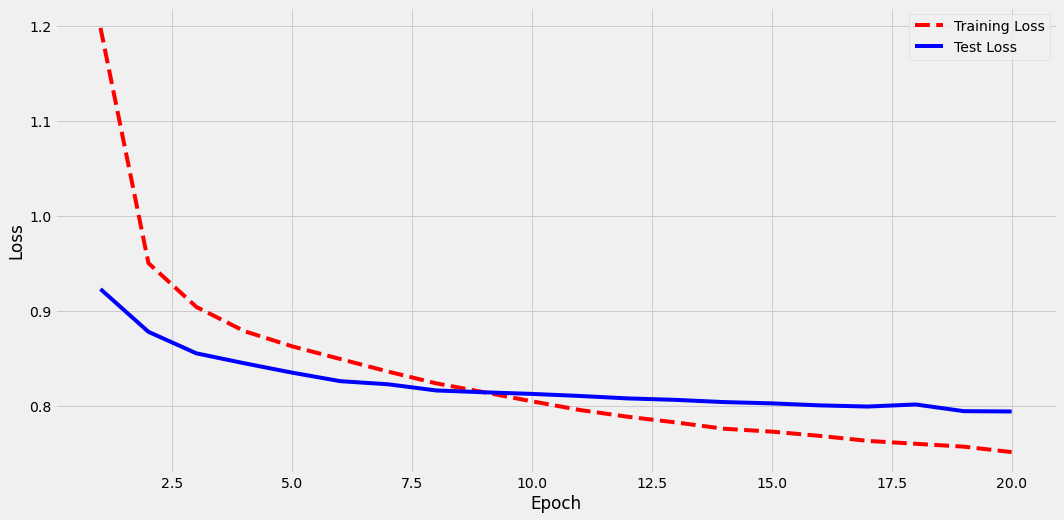

In [26]:
# Get training and test loss histories
training_loss = history.history['loss']
test_loss = history.history['val_loss']

# Create count of the number of epochs
epoch_count = range(1, len(training_loss) + 1)

# Visualize loss history
plt.plot(epoch_count, training_loss, 'r--')
plt.plot(epoch_count, test_loss, 'b-')
plt.legend(['Training Loss', 'Test Loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

In [27]:
pred = model.predict(test_dataset, verbose=1)

96/96 [==============================] - 320s 3s/step


In [28]:
# drop existing feature
test_df = test_df.drop('category', axis=1)

# change with prediction
test_df['category'] = pred.argmax(axis=1)

# then add zero-padding
test_df['category'] = test_df['category'].apply(lambda x: str(x).zfill(2))

In [29]:
print(test_df)

                                   filename category
0      fd663cf2b6e1d7b02938c6aaae0a32d2.jpg       20
1      c7fd77508a8c355eaab0d4e10efd6b15.jpg       27
2      127f3e6d6e3491b2459812353f33a913.jpg       04
3      5ca4f2da11eda083064e6c36f37eeb81.jpg       22
4      46d681a542f2c71be017eef6aae23313.jpg       12
...                                     ...      ...
12181  5ba958eacb23cd7d1673bad4dae55784.jpg       16
12182  efbe41a1c2b666b70e337e438559808b.jpg       19
12183  79fdaa5ac5ba10dbe8004cabd8c35eb3.jpg       34
12184  ac3d136124617637a05ba66694e381ef.jpg       15
12185  7ef61d7cfbad9cfe2db4f64560e3dddd.jpg       23

[12186 rows x 2 columns]


## Make a submission

In [30]:
test_df.to_csv('/kaggle/working/submission_5_tm.csv', index=False)

In [31]:
test_df.head()

,filename,category
0,fd663cf2b6e1d7b02938c6aaae0a32d2.jpg,20
1,c7fd77508a8c355eaab0d4e10efd6b15.jpg,27
2,127f3e6d6e3491b2459812353f33a913.jpg,04
3,5ca4f2da11eda083064e6c36f37eeb81.jpg,22
4,46d681a542f2c71be017eef6aae23313.jpg,12


In [32]:
# from IPython.display import FileLink
# FileLink('/kaggle/working/submission_4_tm.csv')

# Reference:

[EfficientNet from Google — Optimally Scaling CNN model architectures with “compound scaling”](https://medium.com/@lessw/efficientnet-from-google-optimally-scaling-cnn-model-architectures-with-compound-scaling-e094d84d19d4)

[Image Classification with EfficientNet: Better performance with computational efficiency](https://medium.com/analytics-vidhya/image-classification-with-efficientnet-better-performance-with-computational-efficiency-f480fdb00ac6)

[EfficientNet: Rethinking Model Scaling for Convolutional Neural Networks](https://medium.com/@nainaakash012/efficientnet-rethinking-model-scaling-for-convolutional-neural-networks-92941c5bfb95)